# Proyek Klasifikasi Gambar: Rice Image Dataset
- **Nama:** Rahmah Fauziah
- **Email:** rahmahfzh1805@gmail.com
- **ID Dicoding:** MC299D5X1751

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahmahfauziah","key":"9304453feb2c5550554a97fe1bb099d2"}'}

In [4]:
!rm -rf rice-image-dataset/

In [5]:
!mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

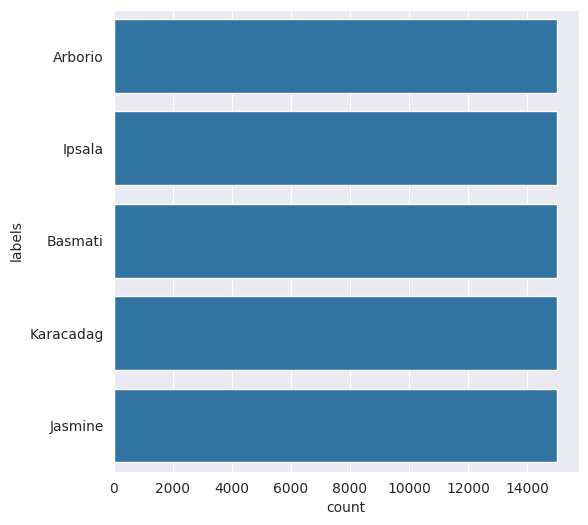

In [7]:
# Define source path
lung_path = "Rice_Image_Dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
      if name.endswith('jpg'):
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [8]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Rice_Image_Dataset/'
selected_labels = ['Arborio', 'Basmati', 'Ipsala']

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
      if name.endswith('jpg'):
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df = df[df["labels"].isin(selected_labels)]
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000


In [9]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=300)

In [10]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [11]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 40500
test size 4500


In [12]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels 
test   Arborio     1535
       Basmati     1509
       Ipsala      1456
train  Arborio    13465
       Basmati    13491
       Ipsala     13544
dtype: int64 


                                                 path   labels    set
33999     Rice_Image_Dataset/Ipsala/Ipsala (5033).jpg   Ipsala  train
845     Rice_Image_Dataset/Arborio/Arborio (9533).jpg  Arborio  train
35853  Rice_Image_Dataset/Basmati/basmati (14731).jpg  Basmati  train
19926   Rice_Image_Dataset/Arborio/Arborio (3588).jpg  Arborio  train
38717   Rice_Image_Dataset/Basmati/basmati (5792).jpg  Basmati  train


In [13]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Rice_Image_Dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [14]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [15]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_arborio = os.path.join(TRAIN_DIR + '/Arborio')
train_basmati = os.path.join(TRAIN_DIR + '/Basmati')
train_ipsala = os.path.join(TRAIN_DIR + '/Ipsala')
test_arborio = os.path.join(TEST_DIR + '/Arborio')
test_basmati = os.path.join(TEST_DIR + '/Basmati')
test_ipsala = os.path.join(TEST_DIR + '/Ipsala')

print("Total number of arborio images in training set: ",len(os.listdir(train_arborio)))
print("Total number of basmati images in training set: ",len(os.listdir(train_basmati)))
print("Total number of ipsala images in training set: ",len(os.listdir(train_ipsala)))
print("Total number of arborio images in test set: ",len(os.listdir(test_arborio)))
print("Total number of basmati images in test set: ",len(os.listdir(test_basmati)))
print("Total number of ipsala images in test set: ",len(os.listdir(test_ipsala)))

Total number of arborio images in training set:  13465
Total number of basmati images in training set:  13491
Total number of ipsala images in training set:  13544
Total number of arborio images in test set:  1535
Total number of basmati images in test set:  1509
Total number of ipsala images in test set:  1456


In [16]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 36451 images belonging to 3 classes.
Found 4049 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


## Modelling

In [17]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,411,139 (20.64 MB)

 Trainable params: 5,410,691 (20.64 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [18]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
count_arborio, count_basmati, count_ipsala = len(os.listdir(train_arborio)), len(os.listdir(train_basmati)), len(os.listdir(train_ipsala))
weight_0 = (1 / count_arborio) * (count_arborio + count_basmati + count_ipsala) / 3.0
weight_1 = (1 / count_basmati) * (count_arborio + count_basmati + count_ipsala) / 3.0
weight_2 = (1 / count_ipsala) * (count_arborio + count_basmati + count_ipsala) / 3.0

class_weights = {0 : weight_0, 1 : weight_1, 2 : weight_2}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=5,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[early_stopping])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1140/1140 ━━━━━━━━━━━━━━━━━━━━ 59s 44ms/step - accuracy: 0.8937 - loss: 0.2991 - val_accuracy: 0.9993 - val_loss: 0.0025
Epoch 2/5
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.9938 - loss: 0.0206 - val_accuracy: 0.9998 - val_loss: 0.0022
Epoch 3/5
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 4/5
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.9966 - loss: 0.0110 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 5/5
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9995 - val_loss: 0.0015


## Evaluasi dan Visualisasi

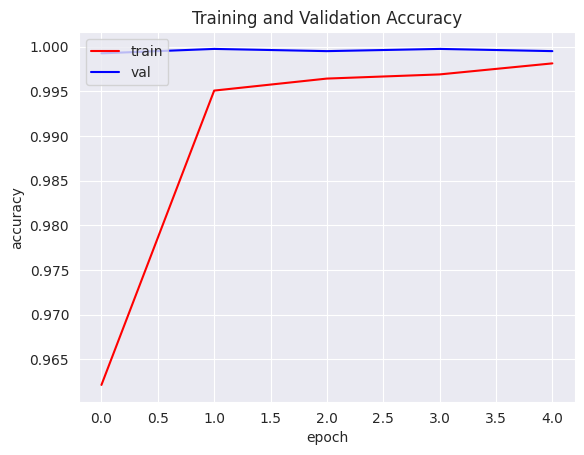

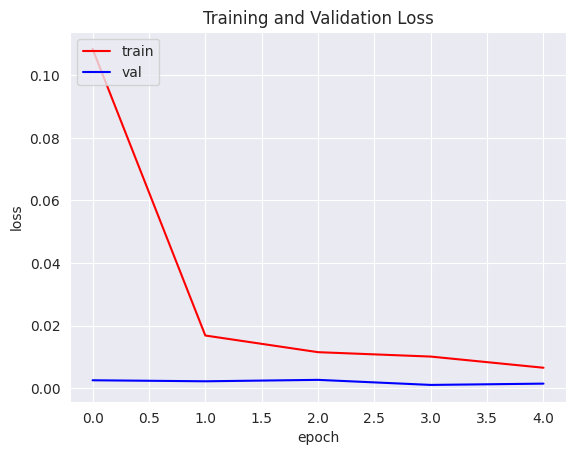

In [20]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()



              precision    recall  f1-score   support

     Arborio     0.9980    0.9993    0.9987      1535
     Basmati     0.9987    1.0000    0.9993      1509
      Ipsala     1.0000    0.9973    0.9986      1456

    accuracy                         0.9989      4500
   macro avg     0.9989    0.9989    0.9989      4500
weighted avg     0.9989    0.9989    0.9989      4500



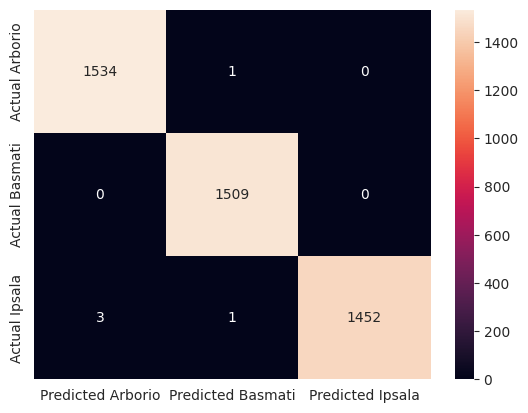

In [21]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1),index=["Actual Arborio", "Actual Basmati", "Actual Ipsala"],
columns=["Predicted Arborio", "Predicted Basmati", "Predicted Ipsala"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Arborio','Basmati', 'Ipsala'], digits=4))

## Konversi Model

In [22]:
model_1.save("model.h5")

In [23]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-30 12:58:11.587609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746017891.606917    2059 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [24]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model_1, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

17180

## Inference (Optional)